In [1]:
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline
from pandas_datareader import data as web

In [2]:
data = pd.DataFrame(web.DataReader('AMZN', data_source='yahoo')['Close'])

In [3]:
data.columns = ['prices']

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2237 entries, 2009-12-31 to 2018-11-16
Data columns (total 1 columns):
prices    2237 non-null float64
dtypes: float64(1)
memory usage: 35.0 KB


In [5]:
data.head()

,prices
Date,
2009-12-31,134.520004
2010-01-04,133.899994
2010-01-05,134.690002
2010-01-06,132.250000
2010-01-07,130.000000


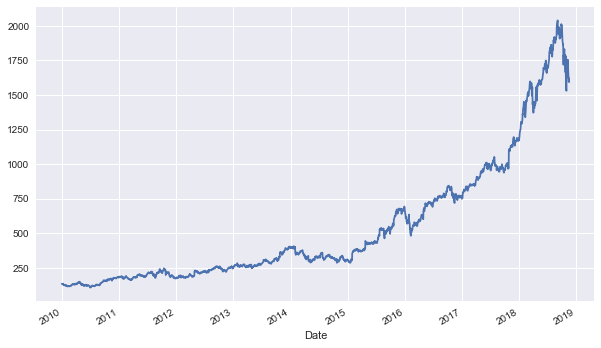

In [6]:
data['prices'].plot(figsize=(10, 6));

In [7]:
data['returns'] = np.log(data / data.shift(1))

In [8]:
lags = 5

In [9]:
cols = []

In [10]:
for lag in range(1, lags+1):
    col = 'ret_%d' % lag
    data[col] = data['returns'].shift(lag)
    cols.append(col)

In [11]:
cols

['ret_1', 'ret_2', 'ret_3', 'ret_4', 'ret_5']

Add momentum values, volatility, VWAP, etc.

In [12]:
data.dropna(inplace=True)

In [13]:
data.head()

,prices,returns,ret_1,ret_2,ret_3,ret_4,ret_5
Date,,,,,,,
2010-01-11,130.309998,-0.024335,0.026717,-0.017160,-0.018282,0.005883,-0.004620
2010-01-12,127.349998,-0.022977,-0.024335,0.026717,-0.017160,-0.018282,0.005883
2010-01-13,129.110001,0.013726,-0.022977,-0.024335,0.026717,-0.017160,-0.018282
2010-01-14,127.349998,-0.013726,0.013726,-0.022977,-0.024335,0.026717,-0.017160
2010-01-15,127.139999,-0.001650,-0.013726,0.013726,-0.022977,-0.024335,0.026717


## Logistic Regression

In [14]:
from sklearn import linear_model

In [15]:
lm = linear_model.LogisticRegression(C = 1e6)

In [16]:
data['direction'] = np.sign(data['returns'])
bh_perf = data['direction'].value_counts()
print('buy-and-hold performance = ' + str(bh_perf[1] / (bh_perf.sum())))

buy-and-hold performance = 0.5302554908112954


In [17]:
lm.fit(data[cols], data['direction'])

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [18]:
data['log_pred'] = lm.predict(data[cols])

In [19]:
data.head()

,prices,returns,ret_1,ret_2,ret_3,ret_4,ret_5,direction,log_pred
Date,,,,,,,,,
2010-01-11,130.309998,-0.024335,0.026717,-0.017160,-0.018282,0.005883,-0.004620,-1.0,1.0
2010-01-12,127.349998,-0.022977,-0.024335,0.026717,-0.017160,-0.018282,0.005883,-1.0,1.0
2010-01-13,129.110001,0.013726,-0.022977,-0.024335,0.026717,-0.017160,-0.018282,1.0,1.0
2010-01-14,127.349998,-0.013726,0.013726,-0.022977,-0.024335,0.026717,-0.017160,-1.0,1.0
2010-01-15,127.139999,-0.001650,-0.013726,0.013726,-0.022977,-0.024335,0.026717,-1.0,1.0


In [20]:
data['log_returns'] = data['returns'] * data['log_pred']

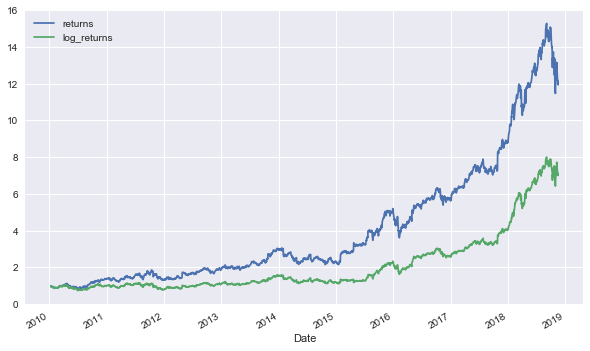

In [21]:
data[['returns', 'log_returns']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6)); 

## Deep Neural Network

In [22]:
import tensorflow as tf

In [23]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [24]:
mean = data['returns'].mean()

In [25]:
std = data['returns'].std()

In [26]:
print(mean, std)

0.0011113314042640208 0.01964515533018753


In [27]:
fc = tf.contrib.layers.real_valued_column('returns', dimension=lags)

In [28]:
fcb = [tf.contrib.layers.bucketized_column(fc,
                    boundaries=[-0.0005, 0.0001, 0.0005])]

In [29]:
model = tf.contrib.learn.DNNClassifier(hidden_units=[50, 50],
                                       feature_columns=fcb)

In [30]:
[len(data), 1]

[2231, 1]

In [31]:
def get_data():
    # Input data
    fc = {'returns': tf.constant(data[cols].values)}
    
    # Expected classification
    la = tf.constant((np.sign(data['returns']) > 0).astype(int).values,
                     shape=[len(data), 1])
    return fc, la

In [32]:
model.fit(input_fn=get_data, steps=100)

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x0000021A08C69FD0>, 'hidden_units': [50, 50], 'feature_columns': (_BucketizedColumn(source_column=_RealValuedColumn(column_name='returns', dimension=5, default_value=None, dtype=tf.float32, normalizer=None), boundaries=(-0.0005, 0.0001, 0.0005)),), 'optimizer': None, 'activation_fn': <function relu at 0x0000021A06F17A60>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [33]:
model.evaluate(input_fn=get_data, steps=1)

{'loss': 0.68733746,
 'accuracy': 0.54504704,
 'labels/prediction_mean': 0.53141975,
 'labels/actual_label_mean': 0.5302555,
 'accuracy/baseline_label_mean': 0.5302555,
 'auc': 0.5561388,
 'auc_precision_recall': 0.57501733,
 'accuracy/threshold_0.500000_mean': 0.54504704,
 'precision/positive_threshold_0.500000_mean': 0.54195803,
 'recall/positive_threshold_0.500000_mean': 0.91715974,
 'global_step': 100}

In [34]:
data['dnn_pred'] = list(model.predict(input_fn=get_data))
data['dnn_pred'] = np.where(data['dnn_pred'] > 0, 1.0, -1.0)

In [35]:
data['dnn_returns'] = data['returns'] * data['dnn_pred']

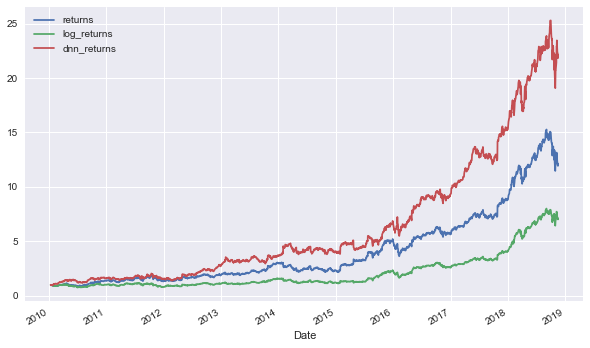

In [36]:
data[['returns', 'log_returns', 'dnn_returns']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));